In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import nltk

# Make sure nltk packages are downloaded (you've done this already)
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('stopwords')

# Define the column names based on the README
column_names = [
    "id", "label", "statement", "subject", "speaker", "speaker_job",
    "state", "party", "barely_true", "false", "half_true", "mostly_true",
    "pants_on_fire", "context"
]

def load_liar_dataset(file_path):
    # Load TSV without header and assign custom column names
    df = pd.read_csv(file_path, sep='\t', header=None, names=column_names)
    print(f"Loaded {file_path} with columns:")
    print(df.columns.tolist())
    print("\nFirst 5 rows:")
    print(df.head())
    return df

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Optionally, join tokens back to string or return tokens
    return " ".join(tokens)

def add_preprocessed_statement(df):
    # Check if the "statement" column exists
    if 'statement' in df.columns:
        df['clean_statement'] = df['statement'].apply(preprocess_text)
    else:
        print("Column 'statement' not found in dataframe!")
    return df

# Load datasets (adjust file paths as necessary)
train_df = load_liar_dataset("data/liar/train.tsv")
valid_df = load_liar_dataset("data/liar/valid.tsv")
test_df = load_liar_dataset("data/liar/test.tsv")

# Preprocess the 'statement' column in the LIAR dataset
train_df = add_preprocessed_statement(train_df)
valid_df = add_preprocessed_statement(valid_df)
test_df = add_preprocessed_statement(test_df)

# Display a sample preprocessed statement from the training set
print("\nExample preprocessed statement:")
print(train_df['clean_statement'].iloc[0])

Loaded data/liar/train.tsv with columns:
['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']

First 5 rows:
           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker           speaker_job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama   

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

# Define a binary label mapping function for LIAR dataset.
# Here, we treat "true" and "mostly-true" as reliable (label 1),
# and all other labels as misleading (label 0).
def map_binary_label(label):
    reliable = ['true', 'mostly-true']
    # lower-case the label to be safe
    return 1 if label.lower() in reliable else 0

# Apply the mapping to the train, valid, and test dataframes
train_df['binary_label'] = train_df['label'].apply(map_binary_label)
valid_df['binary_label'] = valid_df['label'].apply(map_binary_label)
test_df['binary_label'] = test_df['label'].apply(map_binary_label)

# Initialize TfidfVectorizer (we use a simple configuration; feel free to tune parameters)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training set clean statements and transform them.
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_statement'])
X_valid_tfidf = tfidf_vectorizer.transform(valid_df['clean_statement'])
X_test_tfidf  = tfidf_vectorizer.transform(test_df['clean_statement'])

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to compute the compound sentiment score for a given text
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Compute sentiment scores for each preprocessed statement in train, valid and test sets
train_sentiment = train_df['clean_statement'].apply(get_sentiment_score).values.reshape(-1, 1)
valid_sentiment = valid_df['clean_statement'].apply(get_sentiment_score).values.reshape(-1, 1)
test_sentiment  = test_df['clean_statement'].apply(get_sentiment_score).values.reshape(-1, 1)

# Combine tf-idf features with sentiment score by horizontally stacking the features
from scipy.sparse import hstack

X_train = hstack([X_train_tfidf, train_sentiment])
X_valid = hstack([X_valid_tfidf, valid_sentiment])
X_test  = hstack([X_test_tfidf, test_sentiment])

# Extract binary labels
y_train = train_df['binary_label'].values
y_valid = valid_df['binary_label'].values
y_test  = test_df['binary_label'].values

# (Optionally, you can also combine train and valid to train a final model.)

# Train a basic Logistic Regression classifier on the training set
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Predict on validation and test sets
y_valid_pred = clf.predict(X_valid)
y_test_pred = clf.predict(X_test)

# Evaluate using basic metrics
print("Validation Metrics:")
print(classification_report(y_valid, y_valid_pred, target_names=["Misleading", "Reliable"]))

print("Test Metrics:")
print(classification_report(y_test, y_test_pred, target_names=["Misleading", "Reliable"]))

# Optionally, display overall accuracy scores:
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Validation Metrics:
              precision    recall  f1-score   support

  Misleading       0.70      0.88      0.78       864
    Reliable       0.49      0.24      0.32       420

    accuracy                           0.67      1284
   macro avg       0.60      0.56      0.55      1284
weighted avg       0.63      0.67      0.63      1284

Test Metrics:
              precision    recall  f1-score   support

  Misleading       0.67      0.88      0.76       818
    Reliable       0.49      0.20      0.29       449

    accuracy                           0.64      1267
   macro avg       0.58      0.54      0.52      1267
weighted avg       0.60      0.64      0.59      1267

Validation Accuracy: 0.6705607476635514
Test Accuracy: 0.6416732438831886


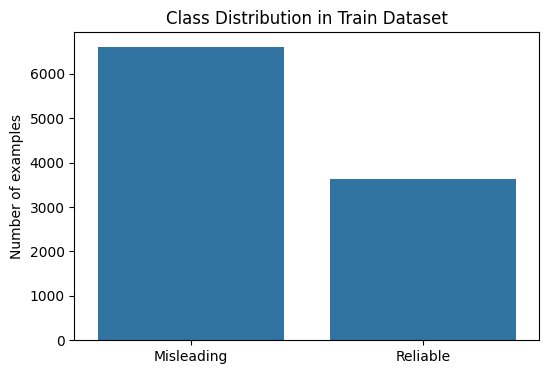

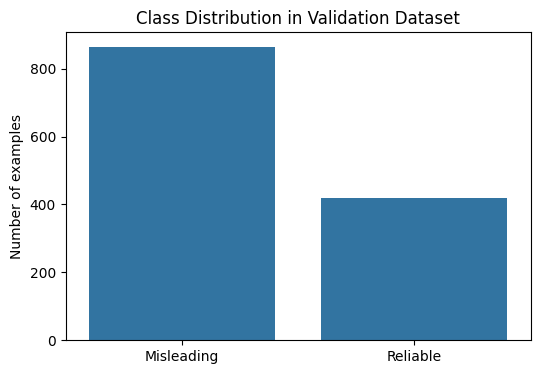

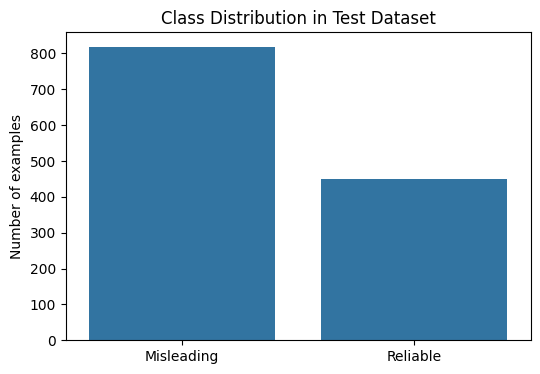

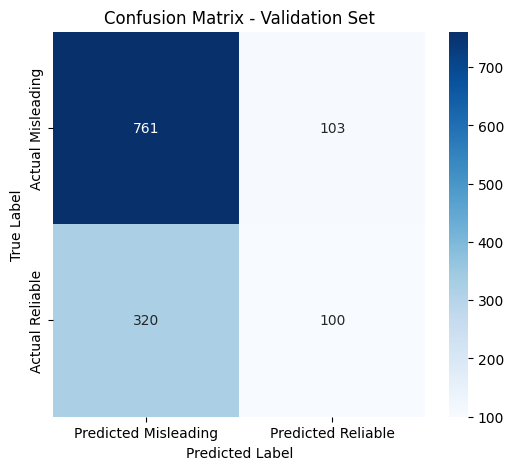

Some misclassified validation examples:
                                            statement  \
3      Says nearly half of Oregons children are poor.   
6   Says Tennessee is providing millions of dollar...   
8   Says Donald Trump started his career back in 1...   
13  The median income of a middle class family wen...   
18  Mark Sharpe has lowered property taxes by 17 p...   
26  We are poised to get rid of over 1,000 more re...   
28  Administrative employees at colleges and unive...   
29  Private prison systems are calculating how man...   
32  We have more kids take the SAT than any other ...   
35  Worldwide credit card transactions, the credit...   

                                      clean_statement        label  \
3              says nearly half oregons children poor    half-true   
6   says tennessee providing millions dollars virt...         true   
8   says donald trump started career back 1973 sue...         true   
13  median income middle class family went 2,100 2..

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Examine Class Distribution
def plot_class_distribution(df, dataset_name):
    counts = df['binary_label'].value_counts().sort_index()
    labels = ["Misleading", "Reliable"]
    plt.figure(figsize=(6,4))
    sns.barplot(x=labels, y=counts.values)
    plt.title(f"Class Distribution in {dataset_name}")
    plt.ylabel("Number of examples")
    plt.show()

plot_class_distribution(train_df, "Train Dataset")
plot_class_distribution(valid_df, "Validation Dataset")
plot_class_distribution(test_df, "Test Dataset")

# 2. Confusion Matrix on Validation Set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Misleading", "Predicted Reliable"],
            yticklabels=["Actual Misleading", "Actual Reliable"])
plt.title("Confusion Matrix - Validation Set")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# 3. Error Analysis: Print a few misclassified examples from the validation set.
misclassified_valid = valid_df[(y_valid != y_valid_pred)]
print("Some misclassified validation examples:")
print(misclassified_valid[['statement', 'clean_statement', 'label', 'binary_label']].head(10))

# 4. (Optional) Inspect feature coefficients from Logistic Regression
feature_names = tfidf_vectorizer.get_feature_names_out().tolist() + ["sentiment"]
coef = clf.coef_[0]
# Get top 10 positive and negative features
top_positive_idx = np.argsort(coef)[-10:]
top_negative_idx = np.argsort(coef)[:10]
print("\nTop positive features (favoring Reliable):")
for idx in top_positive_idx:
    print(f"{feature_names[idx]}: {coef[idx]:.3f}")
print("\nTop negative features (favoring Misleading):")
for idx in top_negative_idx:
    print(f"{feature_names[idx]}: {coef[idx]:.3f}")


In [4]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Make sure the required nltk resources are downloaded
# nltk.download('punkt')
# nltk.download('stopwords')

# Define a preprocessing function (same as before)
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Return preprocessed text as a string
    return " ".join(tokens)

# Load the Clickbait dataset
def load_clickbait_dataset(file_path):
    # The file is a CSV; assume comma delimiter and header row is present
    df = pd.read_csv(file_path)
    # If the header is not parsed correctly (i.e. it's a single column),
    # we can manually split the first column. But assuming it loads properly:
    print(f"Loaded {file_path} with columns:")
    print(df.columns.tolist())
    print("\nFirst 5 rows:")
    print(df.head())
    return df

# Preprocess the 'headline' column
def add_preprocessed_headline(df):
    if 'headline' in df.columns:
        df['clean_headline'] = df['headline'].apply(preprocess_text)
    else:
        print("Column 'headline' not found in dataframe!")
    return df

# Convert clickbait column to binary numeric labels if needed
def convert_clickbait_labels(df):
    # Assume that the 'clickbait' column is in numeric form already or as strings like "1", "0"
    # Convert to int, then map 1 to 1 (clickbait) and 0 to 0 (non-clickbait)
    df['clickbait'] = df['clickbait'].astype(int)
    return df

# Run the preprocessing steps
clickbait_df = load_clickbait_dataset("data/clickbait/clickbait_data.csv")
clickbait_df = convert_clickbait_labels(clickbait_df)
clickbait_df = add_preprocessed_headline(clickbait_df)

# Inspect the first few preprocessed headlines
print("\nExample preprocessed headline:")
print(clickbait_df['clean_headline'].iloc[0])


Loaded data/clickbait/clickbait_data.csv with columns:
['headline', 'clickbait']

First 5 rows:
                                            headline  clickbait
0                                 Should I Get Bings          1
1      Which TV Female Friend Group Do You Belong In          1
2  The New "Star Wars: The Force Awakens" Trailer...          1
3  This Vine Of New York On "Celebrity Big Brothe...          1
4  A Couple Did A Stunning Photo Shoot With Their...          1

Example preprocessed headline:
get bings


Loaded data/clickbait/clickbait_data.csv with columns:
['headline', 'clickbait']

First 5 rows:
                                            headline  clickbait
0                                 Should I Get Bings          1
1      Which TV Female Friend Group Do You Belong In          1
2  The New "Star Wars: The Force Awakens" Trailer...          1
3  This Vine Of New York On "Celebrity Big Brothe...          1
4  A Couple Did A Stunning Photo Shoot With Their...          1

Train Dataset Metrics:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     12874
           1       0.98      0.96      0.97     12726

    accuracy                           0.97     25600
   macro avg       0.97      0.97      0.97     25600
weighted avg       0.97      0.97      0.97     25600



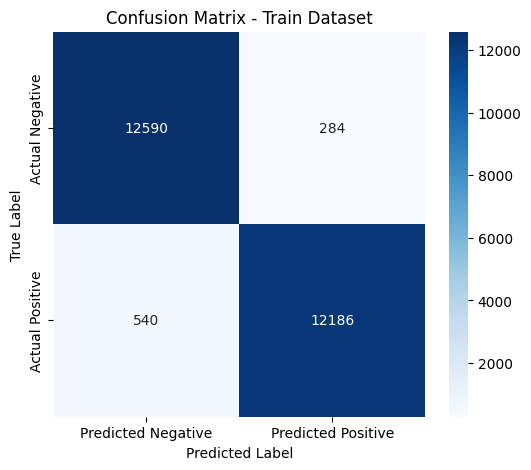


Test Dataset Metrics:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3127
           1       0.97      0.93      0.95      3273

    accuracy                           0.95      6400
   macro avg       0.95      0.95      0.95      6400
weighted avg       0.95      0.95      0.95      6400



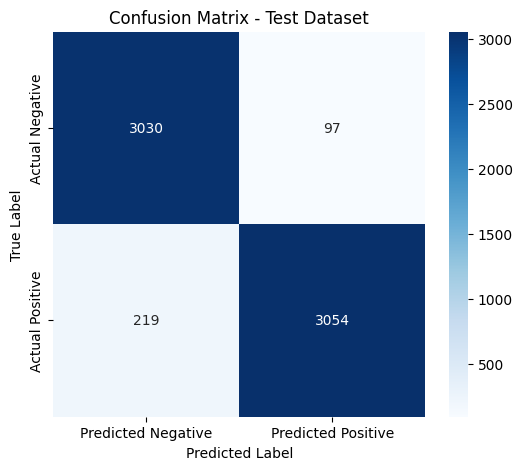

In [6]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure nltk packages are downloaded
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

# Load the clickbait dataset CSV
def load_clickbait_dataset(file_path):
    df = pd.read_csv(file_path)
    print(f"Loaded {file_path} with columns:")
    print(df.columns.tolist())
    print("\nFirst 5 rows:")
    print(df.head())
    return df

# Preprocess text similar to before
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

# Add preprocessed headlines column
def add_preprocessed_headline(df):
    if 'headline' in df.columns:
        df['clean_headline'] = df['headline'].apply(preprocess_text)
    else:
        print("Column 'headline' not found in dataframe!")
    return df

# Extract features: TF-IDF and sentiment scores
def extract_features(df):
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_features = tfidf_vectorizer.fit_transform(df['clean_headline'])
    
    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    sentiments = df['clean_headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
    
    # Combine TF-IDF features and sentiment scores into a single feature matrix
    # We convert sentiment scores to a column vector and then hstack
    from scipy.sparse import hstack
    sentiment_features = np.array(sentiments).reshape(-1, 1)
    # Convert sentiment_features to sparse matrix for stacking
    from scipy import sparse
    sentiment_features_sparse = sparse.csr_matrix(sentiment_features)
    
    X = hstack([tfidf_features, sentiment_features_sparse])
    return X, tfidf_vectorizer

# Train a basic binary classifier (Logistic Regression)
def train_classifier(X_train, y_train):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    return clf

# Evaluate the classifier
def evaluate_model(clf, X, y, dataset_name="Dataset"):
    y_pred = clf.predict(X)
    print(f"\n{dataset_name} Metrics:")
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
    return y_pred

# Main execution for clickbait dataset
if __name__ == "__main__":
    clickbait_df = load_clickbait_dataset("data/clickbait/clickbait_data.csv")
    # Depending on the CSV, if it doesn't have a header split by comma, you might need to adjust.
    # For now, let's assume it has columns like "headline" and "clickbait"
    
    # Preprocess headlines
    clickbait_df = add_preprocessed_headline(clickbait_df)
    
    # Convert clickbait labels to binary: assuming 1 indicates clickbait (i.e., misleading) and 0 indicates reliable
    # If your file has column "clickbait" with values like 1 and 0, then:
    clickbait_df['binary_label'] = clickbait_df['clickbait'].astype(int)
    
    # Extract features
    X, tfidf_vectorizer = extract_features(clickbait_df)
    
    # Split data (e.g., 80/20 train-test split)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, clickbait_df['binary_label'], test_size=0.2, random_state=42)
    
    # Train classifier
    clf = train_classifier(X_train, y_train)
    
    # Evaluate on train and test sets
    evaluate_model(clf, X_train, y_train, "Train Dataset")
    evaluate_model(clf, X_test, y_test, "Test Dataset")


In [7]:
# Check for duplicate statements between train and test
train_statements = set(train_df['clean_statement'])
test_statements = set(test_df['clean_statement'])
duplicates = train_statements.intersection(test_statements)
print(f"Number of duplicate statements between train and test: {len(duplicates)}")


Number of duplicate statements between train and test: 5


In [8]:
# Get top words from each class in the clickbait dataset
from sklearn.feature_extraction.text import TfidfVectorizer

# Assume you have a 'label' column where 1 indicates clickbait and 0 non-clickbait
clickbait_text = clickbait_df[clickbait_df['clickbait'] == 1]['headline']
non_clickbait_text = clickbait_df[clickbait_df['clickbait'] == 0]['headline']

vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
tfidf_clickbait = vectorizer.fit_transform(clickbait_text)
tfidf_nonclickbait = vectorizer.fit_transform(non_clickbait_text)

feature_names = vectorizer.get_feature_names_out()

# Sum tf-idf scores and sort
clickbait_scores = tfidf_clickbait.sum(axis=0).A1
non_clickbait_scores = tfidf_nonclickbait.sum(axis=0).A1

top_clickbait_words = sorted(zip(feature_names, clickbait_scores), key=lambda x: x[1], reverse=True)
top_non_clickbait_words = sorted(zip(feature_names, non_clickbait_scores), key=lambda x: x[1], reverse=True)

print("Top words in clickbait headlines:")
print(top_clickbait_words)

print("\nTop words in non-clickbait headlines:")
print(top_non_clickbait_words)


Top words in clickbait headlines:
[('million', 634.9583070431433), ('president', 616.3843679985882), ('government', 531.2283821935107), ('kills', 516.9440740910543), ('air', 482.3209483642892), ('australian', 448.8960558912196), ('case', 440.00252042348586), ('attack', 412.8153499189161), ('iran', 401.549526402845), ('australia', 364.68920271653127), ('court', 362.8081792984827), ('china', 352.5973991470198), ('man', 349.8095631014536), ('south', 349.01419252988944), ('london', 313.20705545956196), ('india', 309.480960688559), ('football', 294.657862607712), ('iraq', 282.1260025681841), ('bomb', 271.5038935459212), ('afghanistan', 271.34433937360876), ('arrested', 264.2728732529926), ('says', 245.600772331769), ('killed', 217.0548263500634), ('win', 202.3907762203264), ('age', 200.69624538695945), ('minister', 199.1182693293775), ('england', 197.71666244281167), ('obama', 197.48420812350594), ('bank', 194.45445657644345), ('world', 192.6714494132707), ('crash', 191.3052352348455), ('el

Clickbait dataset label distribution:
clickbait
0    16001
1    15999
Name: count, dtype: int64


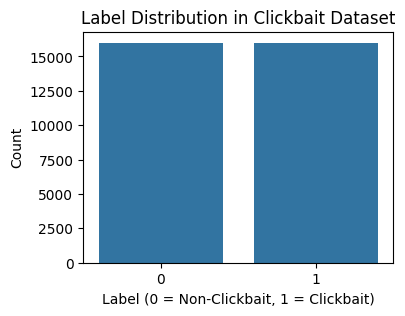

In [9]:
# Check label distribution in clickbait data
label_counts = clickbait_df['clickbait'].value_counts()
print("Clickbait dataset label distribution:")
print(label_counts)

# Visualize it
plt.figure(figsize=(4,3))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Label (0 = Non-Clickbait, 1 = Clickbait)")
plt.ylabel("Count")
plt.title("Label Distribution in Clickbait Dataset")
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

# Example: if you haven't already done so for the clickbait dataset:
X = clickbait_df['headline']
y = clickbait_df['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 25600
Test set size: 6400


In [11]:
train_headlines = set(X_train)
test_headlines = set(X_test)
overlap = train_headlines.intersection(test_headlines)
print(f"Overlap in headlines between train and test: {len(overlap)}")


Overlap in headlines between train and test: 0
